In [1]:
import numpy as np
import torch
import scipy.io
import matplotlib.pyplot as plt
from constrained_nn_eq_discovery import numerics
from constrained_nn_eq_discovery import preprocess
from constrained_nn_eq_discovery import interpolate
from constrained_nn_eq_discovery import utils

def porous(huge_u):
    u, u_x, u_xx, u_y, u_yy, u_xy = huge_u.T
    u_t = (
        0.6 * u * u_xx +
        0.6 * u_x**2 -
        1.6 * u * u_xy -
        1.6 * u_x * u_y +
        2.0 * u * u_yy +
        2.0 * u_y**2
    )
    return u_t.unsqueeze(1)

data_filename = '../data/porous.mat'
sol = preprocess.load_data_2D(data_filename)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

n_xs = np.logspace(np.log10(25), np.log10(150), 10).astype(int)
l2s = np.zeros((len(n_xs), 4))

for i, n_x in enumerate(n_xs):
    n_t = 15 * n_x

    x_vec = torch.linspace(sol.x.min(), sol.x.max(), n_x)
    t_vec = torch.linspace(sol.t.min(), sol.t.max(), n_t)
    X_vec, _ = torch.meshgrid(x_vec, x_vec, indexing='ij')

    U0 = utils.porous_analytic_ic(X_vec, X_vec.T)

    # all to device
    U0 = U0.to(device)
    x_vec = x_vec.to(device)
    t_vec = t_vec.to(device)

    with torch.no_grad():
        U_pde1 = numerics.solve_pde_2d(U0, x_vec, x_vec, t_vec, porous).cpu()
        U_pde2 = numerics.solve_pde_2d(U0, x_vec, x_vec, t_vec, porous, integration_scheme=numerics.midpoint).cpu()
        U_pde3 = numerics.solve_pde_2d_5pt(U0, x_vec, x_vec, t_vec, porous).cpu()
        U_pde4 = numerics.solve_pde_2d_5pt(U0, x_vec, x_vec, t_vec, porous, integration_scheme=numerics.midpoint).cpu()


    for j, U_pde in enumerate([U_pde1, U_pde2, U_pde3, U_pde4]):
        U_intp = interpolate.interpolate_3d(U_pde, sol.U)
        l2 = utils.l2_error(sol.U, U_intp)
        l2s[i, j] = l2
    print(f'L2 error: {l2s[i]}')

L2 error: [0.14176542 0.14176495 0.09006112 0.09006155]
L2 error: [0.12199999 0.12200069 0.07523151 0.07523268]
L2 error: [0.09196493 0.09196589 0.05408945 0.05409062]
L2 error: [0.07435074 0.0743518  0.04168253 0.04168361]
L2 error: [0.0608363  0.06083751 0.03278343 0.03278457]
L2 error: [0.04922293 0.04922395 0.02511816 0.02511908]
L2 error: [0.04102518 0.04102613 0.0201315  0.02013234]
L2 error: [0.0347394  0.03474033 0.01646816 0.01646898]
L2 error: [0.02875738 0.0287582  0.01308388 0.01308457]
L2 error: [0.02434781 0.02434856 0.01078089        nan]


In [7]:
# perf timer
from time import perf_counter

n_x1 = n_xs[-1]
n_x2 = n_xs[-4]

x_vec = torch.linspace(sol.x.min(), sol.x.max(), n_x2)
X_vec, _ = torch.meshgrid(x_vec, x_vec, indexing='ij')
U0 = utils.porous_analytic_ic(X_vec, X_vec.T)
t_vec = torch.linspace(sol.t.min(), sol.t.max(), 15 * n_x2)
# to device
U0 = U0.to(device)
x_vec = x_vec.to(device)
t_vec = t_vec.to(device)

t1 = perf_counter()
numerics.solve_pde_2d_5pt(U0, x_vec, x_vec, t_vec, porous, integration_scheme=numerics.midpoint)
# numerics.solve_pde_2d_5pt(U0, x_vec, x_vec, t_vec, porous, integration_scheme=numerics.rk4)
t2 = perf_counter()
print(f'Elapsed time: {t2 - t1}')

x_vec = torch.linspace(sol.x.min(), sol.x.max(), n_x1)
X_vec, _ = torch.meshgrid(x_vec, x_vec, indexing='ij')
U0 = utils.porous_analytic_ic(X_vec, X_vec.T)
t_vec = torch.linspace(sol.t.min(), sol.t.max(), 15 * n_x1)

U0 = U0.to(device)
x_vec = x_vec.to(device)
t_vec = t_vec.to(device)

t1 = perf_counter()
numerics.solve_pde_2d(U0, x_vec, x_vec, t_vec, porous, integration_scheme=numerics.midpoint)
# numerics.solve_pde_2d(U0, x_vec, x_vec, t_vec, porous, integration_scheme=numerics.rk4)
t2 = perf_counter()
print(f'Elapsed time: {t2 - t1}')

Elapsed time: 1.8822250999510288
Elapsed time: 3.192314599873498


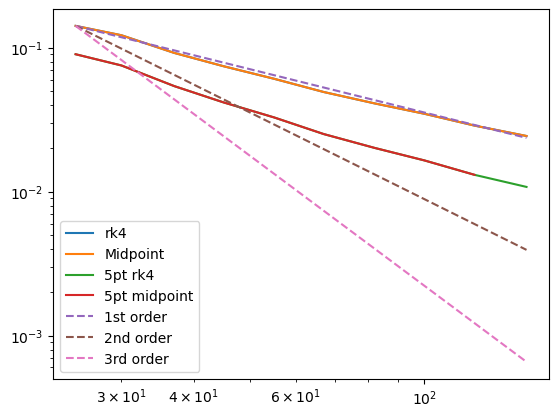

In [8]:
plt.figure()
plt.loglog(n_xs, l2s)
plt.loglog(n_xs, (n_xs[0] / n_xs)**1 * l2s[0,0], '--')
plt.loglog(n_xs, (n_xs[0] / n_xs)**2 * l2s[0,0], '--')
plt.loglog(n_xs, (n_xs[0] / n_xs)**3 * l2s[0,0], '--')
plt.legend(['rk4', 'Midpoint', '5pt rk4', '5pt midpoint', '1st order', '2nd order', '3rd order'])